# Pulire i Dati - Un Esempio Realistico 🕵️‍♀️

Spesso si dice che un modello di machine learning è valido quanto i dati con cui viene addestrato. Per questo, prima di costruire modelli complessi, un data scientist passa gran parte del suo tempo a **capire e pulire i dati**.

In questa lezione, simuleremo uno scenario reale. Lavoriamo per un servizio di streaming (come Netflix) e ci viene dato un piccolo set di dati sui clienti. L'obiettivo finale sarà predire chi disdirà l'abbonamento (`churn`).

Il nostro compito è ispezionare questi dati "grezzi" per identificare e risolvere due problemi comuni:
1.  **Feature Inutili**: Dati che non portano alcuna informazione (bassa varianza).
2.  **Feature Ridondanti**: Dati che ripetono la stessa informazione (alta correlazione).

In [3]:
import pandas as pd
import numpy as np

# Creiamo un dizionario con i dati dei nostri clienti
dati_grezzi = {
    'ore_viste_ultimo_mese': [15, 80, 5, 40, 55, 2, 25, 30],
    'giorni_attivi_ultimo_mese': [10, 28, 4, 20, 22, 1, 15, 18],
    'minuti_visti_ultimo_mese': [900, 4800, 300, 2400, 3300, 120, 1500, 1800],
    'prezzo_abbonamento': [9.99, 9.99, 9.99, 9.99, 9.99, 9.99, 9.99, 9.99],
    'iscrizione_newsletter': [1, 1, 0, 1, 0, 0, 1, 1],
    'churn': [1, 0, 1, 0, 0, 1, 1, 0] # 1 = ha disdetto, 0 = è rimasto
}

# Creiamo il DataFrame
df = pd.DataFrame(dati_grezzi)

print("Ecco le prime 5 righe del nostro dataset grezzo:")
display(df.head())

print("\n--- Statistiche Descrittive ---")
# Il metodo .describe() è FONDAMENTALE per una prima analisi.
# Ci dà media, deviazione standard (std), min, max, etc.
display(df.describe())

Ecco le prime 5 righe del nostro dataset grezzo:


,ore_viste_ultimo_mese,giorni_attivi_ultimo_mese,minuti_visti_ultimo_mese,prezzo_abbonamento,iscrizione_newsletter,churn
0,15,10,900,9.99,1,1
1,80,28,4800,9.99,1,0
2,5,4,300,9.99,0,1
3,40,20,2400,9.99,1,0
4,55,22,3300,9.99,0,0



--- Statistiche Descrittive ---


,ore_viste_ultimo_mese,giorni_attivi_ultimo_mese,minuti_visti_ultimo_mese,prezzo_abbonamento,iscrizione_newsletter,churn
count,8.000000,8.000000,8.000000,8.00,8.000000,8.000000
mean,31.500000,14.750000,1890.000000,9.99,0.625000,0.500000
std,26.365562,9.207916,1581.933717,0.00,0.517549,0.534522
min,2.000000,1.000000,120.000000,9.99,0.000000,0.000000
25%,12.500000,8.500000,750.000000,9.99,0.000000,0.000000
50%,27.500000,16.500000,1650.000000,9.99,1.000000,0.500000
75%,43.750000,20.500000,2625.000000,9.99,1.000000,1.000000
max,80.000000,28.000000,4800.000000,9.99,1.000000,1.000000


### 1. Alla Scoperta delle Feature Inutili (Analisi della Varianza)

Una feature è utile se i suoi valori cambiano. Se è costante per tutti, non può aiutarci a distinguere tra chi disdice e chi no.

**Guardiamo la tabella "Statistiche Descrittive" qui sopra.** Noti qualcosa di strano?

Nella riga `std` (deviazione standard, una misura di quanto i valori variano attorno alla media), la colonna `prezzo_abbonamento` ha valore **0.0**. Questo significa che ogni singolo cliente nel nostro dataset ha lo stesso prezzo di abbonamento.

**Perché è realistico?** È molto comune. Magari questi dati provengono da una campagna marketing rivolta solo a clienti con il piano "Standard". Di conseguenza, per *questo specifico dataset*, la feature `prezzo_abbonamento` è inutile.

In [5]:
# Identifichiamo programmaticamente le colonne con varianza zero
varianze = df.var()
colonne_inutili = varianze[varianze == 0].index
print(f"Feature con varianza zero trovate: {list(colonne_inutili)}")

# Rimuoviamo queste colonne dal nostro DataFrame
df_pulito = df.drop(columns=colonne_inutili)

print("\nDataset dopo aver rimosso la feature inutile:")
display(df_pulito.head())

Feature con varianza zero trovate: ['prezzo_abbonamento']

Dataset dopo aver rimosso la feature inutile:


,ore_viste_ultimo_mese,giorni_attivi_ultimo_mese,minuti_visti_ultimo_mese,iscrizione_newsletter,churn
0,15,10,900,1,1
1,80,28,4800,1,0
2,5,4,300,0,1
3,40,20,2400,1,0
4,55,22,3300,0,0


### 2. Alla Scoperta delle Feature Ridondanti (Analisi della Correlazione)

Ora cerchiamo feature che, pur avendo nomi diversi, ci danno la stessa informazione. Includerle entrambe è come dare a un modello due fotocopie dello stesso documento: non aggiunge valore e può creare confusione.

Lo strumento migliore per scovarle è la **heatmap di correlazione**. La correlazione misura come due variabili si muovono insieme, con un valore che va da -1 a 1.
* **1**: Correlazione positiva perfetta (se una cresce, l'altra cresce della stessa proporzione).
* **-1**: Correlazione negativa perfetta (se una cresce, l'altra decresce della stessa proporzione).
* **0**: Nessuna correlazione.

Cercheremo valori vicini a 1 o -1.

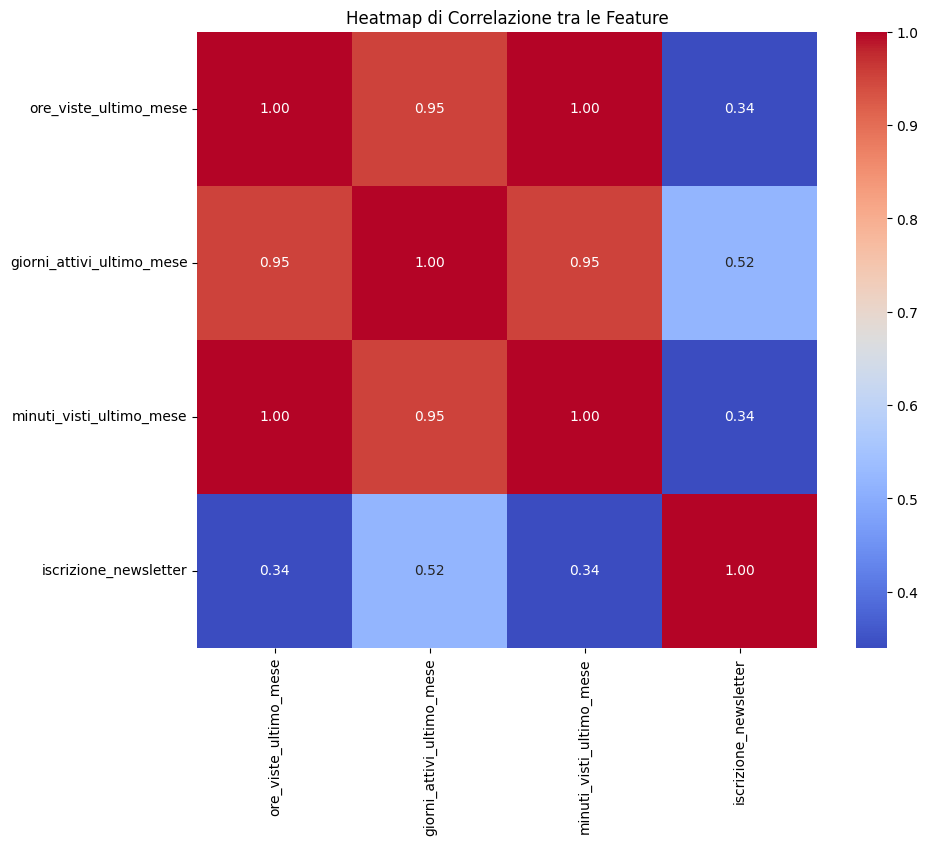

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcoliamo la matrice di correlazione sul DataFrame pulito
# Escludiamo la colonna target 'churn' per analizzare solo le feature tra di loro
matrice_correlazione = df_pulito.drop(columns=['churn']).corr()

# Creiamo la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_correlazione, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap di Correlazione tra le Feature')
plt.show()

### Analisi della Heatmap

Dalla mappa di calore emergono due cose evidenti:

1.  C'è una correlazione **perfetta (1.00)** tra `ore_viste_ultimo_mese` e `minuti_visti_ultimo_mese`. Questo è logico: una è semplicemente l'altra moltiplicata per 60! Sono la stessa identica informazione. Dobbiamo assolutamente rimuoverne una.

2.  C'è una correlazione **molto alta (0.98)** tra `ore_viste_ultimo_mese` e `giorni_attivi_ultimo_mese`. Anche questo è intuitivo: chi guarda più ore di contenuti è probabilmente attivo sulla piattaforma per più giorni. Non sono *perfettamente* ridondanti, ma sono molto simili.

**Decisione Finale:**
* Rimuoviamo `minuti_visti_ultimo_mese` perché è una copia esatta di `ore_viste_ultimo_mese`.
* Per ora teniamo sia `ore_viste` che `giorni_attivi`, ma in un progetto avanzato potremmo decidere di tenere solo la feature più predittiva delle due per semplificare ulteriormente il modello.

Questa lezione ci insegna che il lavoro di preparazione dei dati è un'indagine investigativa che ci permette di fornire al nostro modello solo "ingredienti" di alta qualità, puliti e non ridondanti.

### 3. Alla Scoperta dei Dati Anomali (Outliers) 🤢

A volte, il problema non è una feature inutile o ridondante, ma un **singolo valore** completamente fuori posto. Un outlier è un'osservazione così diversa dalle altre da sembrare un errore di misurazione o di inserimento dati.

**Analogia dello Chef:** Un outlier è come trovare un sasso nella zuppa. Anche se tutti gli altri ingredienti sono perfetti, quel singolo elemento può rovinare l'intero piatto.

**Perché sono un problema?** Molti modelli, specialmente quelli basati su medie e distanze, sono molto sensibili agli outliers. Un singolo valore estremo può "trascinare" una retta di regressione o distorcere completamente il calcolo delle distanze, portando a conclusioni sbagliate.

**Esempio Realistico:** Nel nostro dataset, cosa succederebbe se un cliente avesse `ore_viste_ultimo_mese = 800`? È fisicamente impossibile, dato che un mese ha circa 720 ore. Si tratta chiaramente di un errore.

Lo strumento migliore per identificare visivamente gli outliers è il **Box Plot**.

--- Statistiche Descrittive con l'Outlier ---


,ore_viste_ultimo_mese,giorni_attivi_ultimo_mese,minuti_visti_ultimo_mese,iscrizione_newsletter,churn
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,116.888889,15.888889,7013.333333,0.666667,0.555556
std,257.351144,9.266127,15441.068616,0.500000,0.527046
min,2.000000,1.000000,120.000000,0.000000,0.000000
25%,15.000000,10.000000,900.000000,0.000000,0.000000
50%,30.000000,18.000000,1800.000000,1.000000,1.000000
75%,55.000000,22.000000,3300.000000,1.000000,1.000000
max,800.000000,28.000000,48000.000000,1.000000,1.000000


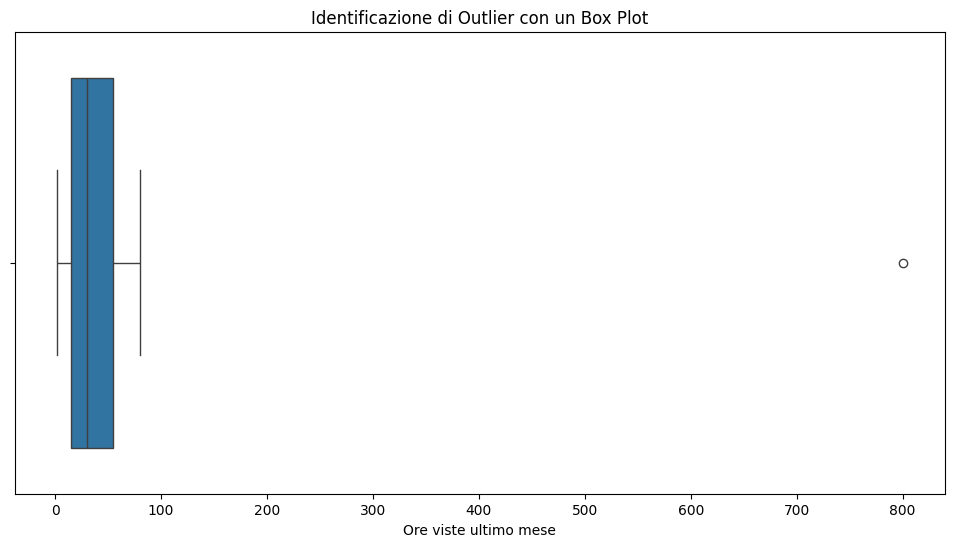


--- Statistiche Descrittive dopo aver rimosso l'Outlier ---


,ore_viste_ultimo_mese,giorni_attivi_ultimo_mese,minuti_visti_ultimo_mese,iscrizione_newsletter,churn
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,31.500000,14.750000,1890.000000,0.625000,0.500000
std,26.365562,9.207916,1581.933717,0.517549,0.534522
min,2.000000,1.000000,120.000000,0.000000,0.000000
25%,12.500000,8.500000,750.000000,0.000000,0.000000
50%,27.500000,16.500000,1650.000000,1.000000,0.500000
75%,43.750000,20.500000,2625.000000,1.000000,1.000000
max,80.000000,28.000000,4800.000000,1.000000,1.000000



Numero di righe prima della rimozione: 9
Numero di righe dopo la rimozione: 8


In [7]:
# Partiamo dal dataframe a cui avevamo già tolto la colonna inutile
df_pulito = df.drop(columns=['prezzo_abbonamento'])

# Creiamo una copia per non modificare l'originale e aggiungiamo un outlier
df_con_outlier = df_pulito.copy()
df_con_outlier.loc[8] = [800, 25, 48000, 1, 1] # Aggiungiamo una nuova riga con dati anomali

print("--- Statistiche Descrittive con l'Outlier ---")
display(df_con_outlier.describe())

# NOTA: Guarda come il valore 'max' di 'ore_viste_ultimo_mese' (800)
# è enormemente diverso dal 75° percentile (61.25). Questo è un primo campanello d'allarme!

# --- Visualizziamo l'outlier con un Box Plot ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_con_outlier, x='ore_viste_ultimo_mese')
plt.title('Identificazione di Outlier con un Box Plot')
plt.xlabel('Ore viste ultimo mese')
plt.show()

# Il punto isolato sulla destra è il nostro outlier. È chiaramente un valore anomalo.

# --- Gestire l'Outlier ---
# In questo caso, essendo un valore impossibile, la scelta più sicura è rimuoverlo.
# Filtriamo il dataframe tenendo solo le righe dove le ore viste sono realistiche (es. < 750)
df_finale = df_con_outlier[df_con_outlier['ore_viste_ultimo_mese'] < 750]

print("\n--- Statistiche Descrittive dopo aver rimosso l'Outlier ---")
display(df_finale.describe())

print(f"\nNumero di righe prima della rimozione: {len(df_con_outlier)}")
print(f"Numero di righe dopo la rimozione: {len(df_finale)}")

### Lezione Imparata
Il box plot ci ha permesso di confermare visivamente il sospetto che avevamo ottenuto dalle statistiche descrittive.

La gestione degli outliers è un passaggio fondamentale della pulizia dei dati. La decisione su **come** gestirli (rimuoverli, correggerli, o tenerli) dipende dal contesto:
* **Se è un errore palese** (come 800 ore in un mese), la rimozione è quasi sempre la scelta giusta.
* **Se è un valore estremo ma plausibile** (es. un cliente che ha visto 200 ore di contenuti), la decisione è più complessa e richiede un'analisi più approfondita del problema.

Questa lezione conclude la nostra introduzione all'analisi e alla pulizia dei dati. Ora siamo davvero pronti per passare a modelli più sofisticati.